In [1]:

import scipy.sparse as sparse
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as m

Ввод данных из файла

In [14]:
# путь к файлу
f = open("1.txt", "r")
all_file = f.readlines()

# Юнг, Пуассон
mu = float(all_file[0].split(' ')[0]) 
E = float(all_file[0].split(' ')[1])

# количество узлов
Num_nod = int(all_file[1])
#список узлов с координатами
Coord_nod = np.matrix([-1,-1])
for i in range(2,Num_nod + 2):
    this_line = all_file[i].split(' ')
    Coord_nod = np.append(Coord_nod,[[float(this_line[0]),float(this_line[1])]],axis = 0)
Coord_nod = np.delete(Coord_nod,0,axis = 0)

# количество конечных элементов
Num_el = int(all_file[Num_nod+2])
#список элементов с соответсвующими узлами
el_nod = np.matrix([-1,-1,-1])
for i in range(Num_nod+3,Num_nod+3+Num_el):
    this_line = all_file[i].split(' ')
    el_nod = np.append(el_nod,[[int(this_line[0]),int(this_line[1]),int(this_line[2])]],axis = 0)
el_nod = np.delete(el_nod,0,axis = 0)

# ограничения движения (?)
lim_in_nod = int(all_file[Num_nod+3+Num_el])
lim = np.matrix([-1,-1])
for i in range(Num_nod+4+Num_el,Num_nod+4+Num_el+lim_in_nod):
    this_line = all_file[i].split(' ')
    lim = np.append(lim,[[float(this_line[0]),float(this_line[1])]],axis = 0)
lim = np.delete(lim,0,axis = 0)

# количество узлов, в которых приложены усилия
eff_in_nod = int(all_file[Num_nod+4+Num_el+lim_in_nod])

eff = np.matrix([-1,-1,-1])
for i in range(Num_nod+5+Num_el+lim_in_nod,Num_nod+5+Num_el+lim_in_nod+eff_in_nod):
    this_line = all_file[i].split(' ')
    eff = np.append(eff,[[float(this_line[0]),float(this_line[1]),float(this_line[2])]],axis = 0)
eff = np.delete(eff,0,axis = 0)





Дальше идёт код для расчёта нагрузки на ребро, я им не пользуюсь

# выясняем нумерацию
kx = 1
ky = 1
old_x = Coord_nod[0,0]
old_y = Coord_nod[0,1]
for i in range(Num_nod):
    if Coord_nod[i,1] != old_y:
        old_y = Coord_nod[i,1]
        ky +=1
kx = Num_nod/ky

def eff_fin(Coord_nod, q, eff,ky):
    eff_q = np.matrix([0,0,0]) # матричка куда будем раписывать нагрузки на ребро
    for i in range(len(q)):
        q_ = q[i,2] # величина нагрузки
        if q[i,3] == 1:
            st = int(q[i,0])
            fin = int(q[i,1])
            x_old = Coord_nod[st,0]
            y_old = Coord_nod[st,1]
            n = fin - st
            j = st + 1
            while j <= fin:
                l = m.sqrt((x_old - Coord_nod[j,0])**2 + (y_old - Coord_nod[j,1])**2)
                eff_q = np.append(eff_q,[[j - 1,0, q_*l/2]],axis = 0)
                eff_q = np.append(eff_q,[[j,0, q_*l/2]],axis = 0)
                x_old = Coord_nod[j,0]
                y_old = Coord_nod[j,1]
                j+=1
        if q[i,3] == 0:
            st = int(q[i,0])
            fin = int(q[i,1])
            x_old = Coord_nod[st,0]
            y_old = Coord_nod[st,1]
            n = fin - st
            j = st + int(ky)
            while j <= fin:
                l = m.sqrt((x_old - Coord_nod[j,0])**2 + (y_old - Coord_nod[j,1])**2)
                eff_q = np.append(eff_q,[[j - ky, q_*l/2, 0]],axis = 0)
                eff_q = np.append(eff_q,[[j, q_*l/2, 0]],axis = 0)
                x_old = Coord_nod[j,0]
                y_old = Coord_nod[j,1]
                j += int(ky)
    eff_q= np.delete(eff_q,0,axis = 0) 
    # теперь надо объединить eff_q и eff
    eff_final = eff
    for j in range(len(eff)):
        for k in range(len(eff_q)):
            if eff[j,0] == eff_q[k,0]:
                eff_final[j,1] = eff[j,1] + eff_q[k,1]
                eff_final[j,2] = eff[j,2] + eff_q[k,2]
                eff_q= np.delete(eff_q,k,axis = 0)
                break
    eff_final = np.append(eff_final,eff_q,axis = 0)
    #eff_final = np.delete(eff_final,0,axis = 0)
    return(eff_final)            
            
        

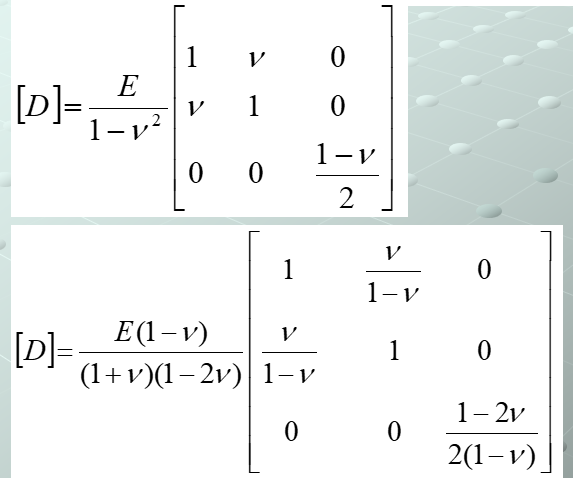

In [15]:
# ищем матрицу D
D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
print(D)

[[2692.30769231 1153.84615385    0.        ]
 [1153.84615385 2692.30769231    0.        ]
 [   0.            0.          769.23076923]]


In [16]:
#функция которой дают номера узлов, соответствующих элементу,
# и матрицу с координатами, а она считает определитель*2
def Det2(xi,yi,xj,yj,xk,yk):
    return (xj*(yk - yi) + xi*(yj - yk) + xk*(yi - yj))

In [17]:
# умножение матрицы на матрицу
def d(A,B):
    ans = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(B.shape[0]):
                ans[i,j] += A[i,k] * B[k,j]
    return ans

In [18]:
# убираем сингулярность
def K_ok(A,lim):
    for i in range(len(lim)):
        for j in range(len(A)):
            if lim[i,0] == j:
                if lim[i,1] == 1:
                    ii = int(lim[i,0]*2)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 2:
                    ii = int(lim[i,0]*2+1)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 3:
                    ii1 = int(lim[i,0]*2)
                    ii0 = int(lim[i,0]*2+1)
                    
                    for k in range(len(A)):
                            A[ii1,k] = 0
                            A[k,ii1] = 0
                            A[ii0,k] = 0
                            A[k,ii0] = 0
                    A[ii1,ii1] = 1
                    A[ii0,ii0] = 1
    
    
    
   
    return A

In [19]:
x,y,z = sp.symbols('x, y, z')
ui,uj,uk = sp.var('ui uj uk')
vi,vj,vk = sp.var('vi vj vk')
wi,wj,wk = sp.var('wi wj wk')

def make_B(num,el_nod,Coord_nod,D,eff,lim):
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    ai = (xj*yk - xk*yj)/Det2(xi,yi,xj,yj,xk,yk)
    aj = (xk*yi - xi*yk)/Det2(xi,yi,xj,yj,xk,yk)
    ak = (xi*yj - xj*yi)/Det2(xi,yi,xj,yj,xk,yk)
    bi = (yj - yk)/Det2(xi,yi,xj,yj,xk,yk)
    bj = (yk - yi)/Det2(xi,yi,xj,yj,xk,yk)
    bk = (yi - yj)/Det2(xi,yi,xj,yj,xk,yk)
    ci = (xk - xj)/Det2(xi,yi,xj,yj,xk,yk)
    cj = (xi - xk)/Det2(xi,yi,xj,yj,xk,yk)
    ck = (xj - xi)/Det2(xi,yi,xj,yj,xk,yk)
   
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
     
    return B0

In [20]:
def make_K(num,el_nod,Coord_nod,D,eff_final,lim):
    Bi = make_B(num,el_nod,Coord_nod,D,eff_final,lim)
  
    return Bi.T.dot(D).dot(Bi)

In [21]:
#make_K(0,el_nod,Coord_nod,D,eff) 

In [22]:
# формируем большую K 
def sum_K(A,B,ind,num):
    a = len(A)
    b = len(B)
    for i in range(ind.shape[1]):
        for j in range(ind.shape[1]):
            ii = ind[0,i]
            jj = ind[0,j]
           
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    
    return A
        

с лентой я пока тоже ничего не делаю

In [23]:
# хранение полуленты
def band(A):
    n = len(A)
    B = np.zeros((n,6))
    A = np.block([A, np.zeros((n,5))])
    for i in range(n):
        B[i,:] = A[i,i:6+i]
    return B

In [33]:
# распаковка полуленты
def band_out(A):
    n = len(A)
    A = np.block([[A, np.zeros((n,n))]])
    B = np.zeros((n,n*2))
    for i in range(n):
        for j in range(n):
            B[i,i+j] = A[i,j]
            B[i,i-j] = B[i-j,i]
    
        
    return B[:,:n]

In [34]:
# генерируем вектор правых частей
def right(eff,num_nod):
    a = np.zeros(Num_nod*2)
    for i in range(len(eff)):
        for j in range(Num_nod):
            if eff[i,0] == j:
                a[j*2] = eff[i,1]
                a[j*2+1] = eff[i,2]
            
    return a

In [37]:
def FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim):
    # нужно косо проссумировать все К
    #eff_final = eff_fin(Coord_nod, q, eff,ky)
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
    
    K0 = K_ok(K0,lim)
    
    U = np.linalg.solve(K0,rig.T)
    max_sig = 0
    max_sig_i = 0
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
    
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        # напряжения\сигма
        Nap = D.dot(Eps) 
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        Sig,s = np.linalg.eig(NapM) 
        #if max(abs(min(Nap)),max(Nap)) > max_sig:
         #   max_sig =  max(abs(min(Nap)),max(Nap)) 
          #  max_sig_i = i
        if np.linalg.norm(Sig) > max_sig:
            max_sig = np.linalg.norm(Sig)
            max_sig_i = i
        #print(Sig,' главные напряжения в ',i)
        #print('Деформация и напряжение в ',i,' элементе',Eps,Nap)
    #print('максимальное напряжение ',max_sig,'в элементе ',max_sig_i)
    print(max_sig,' норма максимальных главных напряжений, элемент ',i)
    return U


In [38]:
FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim)

1.4022050939392157  норма максимальных главных напряжений, элемент  1


array([ 0.00000000e+00,  0.00000000e+00, -1.41046936e-04,  1.39785106e+12,
       -1.39785106e+12,  5.34357361e-04, -1.39785106e+12,  1.39785106e+12])

In [39]:
el_nod[3117,:]

IndexError: index 3117 is out of bounds for axis 0 with size 2

In [ ]:
print(Coord_nod[742,0],Coord_nod[742,1])